In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from json_data_getter import get_all_json

## Data loading

In [2]:
# gets all the json files toghether, may take a minute
number_documents, keys, documents = get_all_json()

In [22]:
df = pd.DataFrame.from_dict(documents)

for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if dt == int or dt == float:
        pass
    else:
        df[col].fillna("", inplace=True)

In [23]:
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

In [223]:
df.columns

Index(['alternativeExcerpt', 'alternativeTitle', 'articleURL', 'backgrounds',
       'contributors', 'durationSec', 'excerpt', 'genres', 'id', 'imageURL',
       'isOnline', 'mediaType', 'mediaURL', 'program',
       'publicationChannelNames', 'publicationDate', 'source',
       'thematicCorporations', 'thematicGeographicals', 'thematicPersons',
       'thematicThemes', 'title', 'variantIds', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes',
       'publicationDateYear'],
      dtype='object')

In [213]:
lenght_ = [len(x) for x in df.loc[df.excerpt != ''].excerpt.values]

In [222]:
lenght_.sort()
lenght_[::-1]

[26347,
 25153,
 23340,
 21729,
 20732,
 20522,
 20413,
 20403,
 19766,
 19678,
 19566,
 19566,
 18894,
 18793,
 18620,
 18589,
 18516,
 18471,
 18225,
 18074,
 18074,
 17893,
 17740,
 17722,
 17685,
 17661,
 17629,
 17616,
 17399,
 17251,
 17244,
 17035,
 17002,
 16990,
 16762,
 16487,
 16415,
 16403,
 16384,
 16382,
 16379,
 16324,
 16140,
 16130,
 16127,
 16093,
 16084,
 16069,
 16052,
 15994,
 15993,
 15973,
 15969,
 15968,
 15933,
 15918,
 15879,
 15790,
 15764,
 15764,
 15740,
 15712,
 15710,
 15710,
 15699,
 15699,
 15673,
 15646,
 15643,
 15625,
 15599,
 15564,
 15537,
 15396,
 15368,
 15349,
 15345,
 15336,
 15329,
 15289,
 15283,
 15279,
 15241,
 15215,
 15212,
 15202,
 15201,
 15157,
 15156,
 15156,
 15155,
 15145,
 15139,
 15123,
 15116,
 15107,
 15082,
 15082,
 15049,
 15032,
 15018,
 14996,
 14996,
 14995,
 14993,
 14984,
 14984,
 14947,
 14934,
 14931,
 14909,
 14882,
 14855,
 14849,
 14813,
 14791,
 14787,
 14783,
 14779,
 14761,
 14729,
 14719,
 14709,
 14689,
 14687,


## distribution in time

In [24]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()

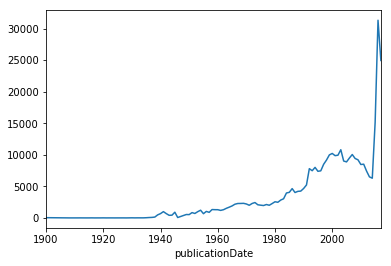

In [25]:
doc_per_year.plot(logy=0)
plt.show()

## Programs duration

In [26]:
def get_show_duration(df):
    program_groups = df.groupby(df.program)
    df_duration = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_duration['duration_days'] = (
        df_duration['max'] - df_duration['min']).astype('timedelta64[D]')
    return df_duration

In [225]:
get_show_duration(df).sort_values('size', ascending=False).head(50)

,min,max,size,duration_days
program,,,,
Journal du matin,1972-07-17 00:00:00,2017-08-28 00:00:00,21799,16478.0
,1900-01-01 00:00:00,2017-11-01 00:00:00,20451,43038.0
Télé journal,1963-12-03 00:00:00,2009-10-15 23:00:00,10520,16753.0
Forum,1992-09-11 00:00:00,2017-11-02 00:00:00,10518,9183.0
Journal de midi,1940-08-27 00:00:00,2017-08-01 00:00:00,8440,28098.0
Le journal,2006-01-09 00:00:00,2014-08-24 00:00:00,7735,3149.0
Journal de 12h30,2015-10-01 00:00:00,2017-11-02 00:00:00,6849,763.0
Le téléjournal,1995-01-09 00:00:00,2001-08-20 00:00:00,6387,2415.0
Les Zap,1993-11-07 00:00:00,2005-01-30 00:00:00,5474,4102.0


Some duration seem a bit too long, maybe there are errors in the dates.

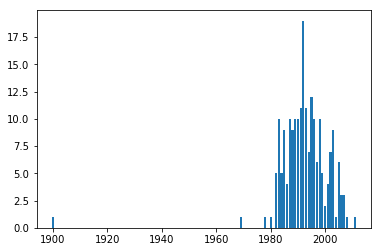

In [28]:
program_groups = df.groupby(df.program)

TJmidi = program_groups.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(
    TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index, TJmidi_date_distribution.values)

plt.show()

In [29]:
# remove outliers
def remove_date_outliers(df):
    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)
    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])
    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)
    df_without_date_outliers = temp_df[(
        np.abs(temp_df.publicationDateYear - temp_df['mean']) <
        2 * temp_df['std'])]
    return df_without_date_outliers

In [30]:
df_without_date_outliers = remove_date_outliers(df)
get_show_duration(df_without_date_outliers).sort_values(
    'duration_days', ascending=False).head()

,min,max,size,duration_days
program,,,,
,1921-11-23,2017-11-01 00:00:00,20363,35042.0
Documentaire,1952-11-30,2017-11-06 20:30:00,740,23717.0
Cyclisme,1953-11-30,2017-08-19 00:00:00,137,23273.0
Motocyclisme,1954-06-09,2017-08-13 00:00:00,14,23076.0
Souvenirs de vedette,1949-03-31,2009-12-17 00:00:00,4,22176.0


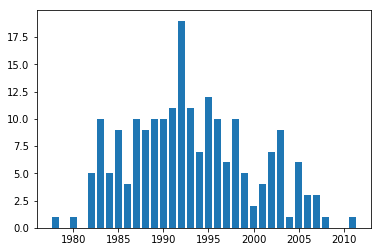

In [31]:
program_groups_without_outliers = df_without_date_outliers.groupby(df.program)

TJmidi = program_groups_without_outliers.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(
    TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index, TJmidi_date_distribution.values)

plt.show()

In [202]:
genra = program_groups_without_outliers.get_group('Documentaire').visualThemes.values
flat_list = [item for sublist in genra for item in sublist]
flat_list
unique, counts = np.unique(flat_list, return_counts=True)
print(unique)
print(counts)

['19E SIÈCLE' 'ABBAYE' "ABORIGÈNES D'AUSTRALIE" 'ABRI ANTIATOMIQUE'
 'ACCIDENT AÉRIEN' 'ACCIDENT DE MONTAGNE' 'ACCORD INTERNATIONAL'
 'ACCOUCHEMENT' 'ACIER' 'ACROBATIE (ART)' 'ACROBATIE AÉRIENNE' 'ADOLESCENT'
 'ADOPTION' 'AGRICULTURE' 'AGRICULTURE DE MONTAGNE' 'AID EL-ADHA'
 'AIDE ALIMENTAIRE' 'AIDE AU DÉVELOPPEMENT' 'AIDE HUMANITAIRE'
 'AIDE MÉDICALE INTERNATIONALE' 'ALCOOL (ALIMENTAIRE)' 'ALCOOLISME'
 'ALCOOLISME AU VOLANT' 'ALPAGE' 'ALPINISME' 'ALTERMONDIALISME' 'AMOUR'
 'AMÉNAGEMENT DU TERRITOIRE' 'AMÉNAGEMENT URBAIN' 'AMÉRINDIENS'
 'ANALYSE CHIMIQUE' 'ANARCHISME' 'ANIMAL EN PELUCHE' 'ANIMAL SAUVAGE'
 'ANIMATION' 'ANIMISME' 'ANNÉES 1930' 'ANNÉES 1940' 'ANNÉES 1950'
 'ANNÉES 1960' 'ANNÉES 1970' 'ANNÉES 1980' 'ANNÉES 2000' 'ANTILOPE'
 'APPAREIL PHOTOGRAPHIQUE' 'APPARTEMENT' 'APPRENTI' 'AQUARIUM'
 'ARCHITECTURE' 'ARITHMÉTIQUE' 'ARME ATOMIQUE' 'ARMISTICE' 'ARMOIRIE'
 'ARMÉE' 'ARMÉE DE TERRE' 'ART BAROQUE' 'ART CULINAIRE' 'ART DRAMATIQUE'
 'ART ET TRADITION POPULAIRES' 'ART GOTHIQUE' 'A

## Genres

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [130]:
genres_per_program = pd.DataFrame()
genres_per_program['genres'] = df_without_date_outliers.visualThemes.apply(lambda x : ' '.join(x))
genres_per_program['program'] = df_without_date_outliers.program
genres = genres_per_program.groupby(genres_per_program.program).agg(lambda x: ' '.join(x))
duration = get_show_duration(df_without_date_outliers)

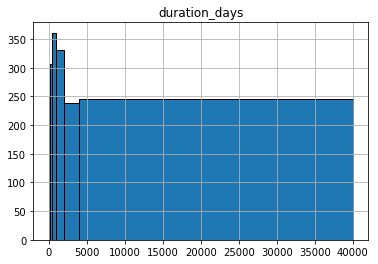

In [131]:
duration.hist(column='duration_days', bins=[-1,250,500,1000,2000,4000,40000], ec='black')
plt.show()

In [171]:
duration['duration_class'] = (pd.qcut(duration.duration_days, 3, labels=[0,1,2]))

In [172]:
evaluate_df = duration.merge(genres, left_index=True, right_index=True)
X = evaluate_df.genres
y = evaluate_df.duration_class

### model selection

In [177]:
count_vect = CountVectorizer(ngram_range=(1,1))
tfidf_transformer = TfidfTransformer()

classifiers = [
    SGDClassifier(alpha=1e-5, random_state=42),
    svm.SVC(),
    RandomForestClassifier(max_depth=5, n_estimators=10)
]

classifiers_name = ['SGDClassifier', 'svc', 'randomforest']

X_count = count_vect.fit_transform(X)
X_tfidf = tfidf_transformer.fit_transform(X_count)

In [178]:
for i,classifier in zip(classifiers_name, classifiers):
    scores = cross_val_score(classifier, X_tfidf, y, cv=5)
    print('for {}'.format(i))
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

for SGDClassifier
Accuracy: 0.372 (+/- 0.067)
for svc
Accuracy: 0.334 (+/- 0.002)
for randomforest
Accuracy: 0.394 (+/- 0.047)


### Grid search for random forest

In [179]:
count_vect = CountVectorizer(ngram_range=(1,2))
tfidf_transformer = TfidfTransformer()
clf = RandomForestClassifier(max_depth=50, random_state=0)

pipeline = Pipeline([
    ('vect', count_vect),
    ('tfidf', tfidf_transformer),
    ('clf', clf),
])

parameters = {
    'vect__max_df': (0.5, 1.0),
    'vect__ngram_range': ((1,1),(1,2)),
    #'clf__max_depth': np.arange(10,51,10),
    'clf__n_estimators': np.power(2,np.arange(1,6,1)),
}

In [180]:
gs_clf = GridSearchCV(pipeline, parameters, n_jobs=2, verbose=10, cv =5)

In [181]:
gs_clf = gs_clf.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   13.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   36.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   56.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  4.6min finished


In [182]:
gs_clf.best_score_ 

0.40334679746105018

In [183]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__n_estimators: 32
vect__max_df: 0.5
vect__ngram_range: (1, 1)


In [184]:
rand

AttributeError: 'Pipeline' object has no attribute 'features_importance'

#### with only 2 labels

In [199]:
(X_tfidf.getrow(2))

In [187]:
RFC = RandomForestClassifier(max_depth=50, n_estimators=32)
RFC.fit(X_tfidf, y)
feat_imp = RFC.feature_importances_

Feature ranking:


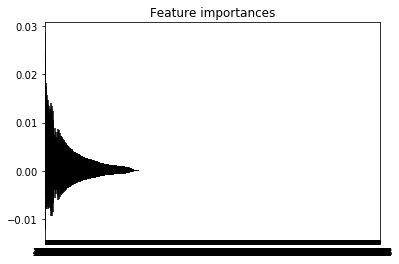

In [192]:
importances = feat_imp
std = np.std([tree.feature_importances_ for tree in RFC.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X_tfidf.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_tfidf.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_tfidf.shape[1]), indices)
plt.xlim([-1, X_tfidf.shape[1]])
plt.show()

In [162]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__max_depth: 50
clf__n_estimators: 8
vect__max_df: 0.5
vect__ngram_range: (1, 1)
